In [1]:
# !gdown --fuzzy "https://drive.google.com/file/d/1A3hCNFQoM9KJy43j8e54Q-beP_vokzY-/view?usp=sharing"
# !unzip -q dataset.zip

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as TF
import torchvision.models as models
from PIL import Image
import numpy as np
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import random_split

In [3]:
# DATASET = '/kaggle/input/sber-sk-practice-dataset-1/dataset'
DATASET = 'dataset'

In [4]:
# -------- 1. Dataset --------
class LithoZernikeDataset(Dataset):
    def __init__(self, root_dir, num_zernike=20, image_size=512, augment=True):
        self.pairs = []  # (input_img_path, target_img_path, coeffs)
        self.num_zernike = num_zernike
        self.image_size = image_size
        self.augment = augment

        for ab_folder in sorted(os.listdir(root_dir)):
            folder_path = os.path.join(root_dir, ab_folder)
            if not os.path.isdir(folder_path):
                continue
            # Parse Zernike index and coefficient from folder name, e.g., "4Z3"
            if 'Z' in ab_folder:
                parts = ab_folder.replace('-', ' -').split('Z')
                coef = float(parts[0])
                idx = int(parts[1])
                coeffs = np.zeros(num_zernike, dtype=np.float32)
                if idx < num_zernike:
                    coeffs[idx] = coef
            else:
                continue

            for imgname in os.listdir(folder_path):
                if not imgname.endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    continue
                input_img_path = os.path.join(folder_path, imgname)
                # Предполагаем, что у тебя есть target-изображение с тем же именем в папке "target"
                target_img_path = os.path.join(root_dir, 'target', imgname)
                self.pairs.append((input_img_path, target_img_path, coeffs.copy()))

        self.transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        input_img_path, target_img_path, coeffs = self.pairs[idx]
        input_img = Image.open(input_img_path).convert('L')
        target_img = Image.open(target_img_path).convert('L')

        # Augmentation (rotation + flip)
        if self.augment:
            angle = np.random.choice([0, 90, 180, 270])
            flip_h = np.random.rand() > 0.5
            flip_v = np.random.rand() > 0.5
            input_img = TF.rotate(input_img, angle)
            target_img = TF.rotate(target_img, angle)
            if flip_h:
                input_img = TF.hflip(input_img)
                target_img = TF.hflip(target_img)
            if flip_v:
                input_img = TF.vflip(input_img)
                target_img = TF.vflip(target_img)

        input_img = self.transform(input_img)  # 1 x H x W
        target_img = self.transform(target_img)
        # Stack to shape [2, H, W]
        imgs = torch.cat([input_img, target_img], dim=0)
        return imgs, torch.from_numpy(coeffs)

In [5]:
def get_backbone(model_name, in_chans=2, pretrained=True, num_classes=20):
    if model_name.startswith('resnet'):
        backbone = getattr(models, model_name)(pretrained=pretrained)
        # Меняем первый слой под два канала
        backbone.conv1 = torch.nn.Conv2d(
            in_chans, backbone.conv1.out_channels,
            kernel_size=backbone.conv1.kernel_size,
            stride=backbone.conv1.stride,
            padding=backbone.conv1.padding,
            bias=False)
        num_features = backbone.fc.in_features
        backbone.fc = torch.nn.Linear(num_features, num_classes)
    elif model_name.startswith('efficientnet'):
        backbone = getattr(models, model_name)(pretrained=pretrained)
        # Первый слой EfficientNet называется "features[0][0]"
        backbone.features[0][0] = torch.nn.Conv2d(
            in_chans, backbone.features[0][0].out_channels,
            kernel_size=3, stride=2, padding=1, bias=False)
        num_features = backbone.classifier[1].in_features
        backbone.classifier[1] = torch.nn.Linear(num_features, num_classes)
    elif model_name.startswith('convnext'):
        backbone = getattr(models, model_name)(pretrained=pretrained)
        backbone.features[0][0] = torch.nn.Conv2d(
            in_chans, backbone.features[0][0].out_channels,
            kernel_size=4, stride=4)
        num_features = backbone.classifier[2].in_features
        backbone.classifier[2] = torch.nn.Linear(num_features, num_classes)
    elif model_name.startswith('swin'):
        backbone = getattr(models, model_name)(pretrained=pretrained)
        backbone.features[0][0] = torch.nn.Conv2d(
            in_chans, backbone.features[0][0].out_channels,
            kernel_size=4, stride=4)
        num_features = backbone.head.in_features
        backbone.head = torch.nn.Linear(num_features, num_classes)
    elif model_name.startswith('vit'):
        backbone = getattr(models, model_name)(pretrained=pretrained)
        # vit expects 3 channels by default, patchify works on in_chans
        backbone.conv_proj = torch.nn.Conv2d(
            in_chans, backbone.conv_proj.out_channels,
            kernel_size=backbone.conv_proj.kernel_size,
            stride=backbone.conv_proj.stride,
            padding=backbone.conv_proj.padding,
            bias=False)
        num_features = backbone.heads.head.in_features
        backbone.heads.head = torch.nn.Linear(num_features, num_classes)
    else:
        raise NotImplementedError(f'Unknown model: {model_name}')
    return backbone

In [6]:
# -------- 2. Model --------
class LithoZernikeRegressor(LightningModule):
    def __init__(self, model_name='efficientnet_b0', num_zernike=20, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.backbone = get_backbone(model_name, in_chans=2, num_classes=num_zernike)

    def forward(self, x):
        return self.backbone(x)

    def training_step(self, batch, batch_idx):
        imgs, coeffs = batch
        preds = self(imgs)
        loss = torch.nn.functional.mse_loss(preds, coeffs)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, coeffs = batch
        preds = self(imgs)
        loss = torch.nn.functional.mse_loss(preds, coeffs)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [7]:
# -------- 3. DataLoader --------
def make_dataloaders(root, batch_size=16, num_zernike=20, split=0.8):
    # train_dataset = LithoZernikeDataset(root, num_zernike=num_zernike, augment=False)
    # val_dataset = LithoZernikeDataset(root, num_zernike=num_zernike, augment=False)
    dataset = LithoZernikeDataset(root, num_zernike=num_zernike, augment=False)
    train_size = int(split * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader

Aberrations: Z=[ 0. -3.  0.  0.  0.  0.]


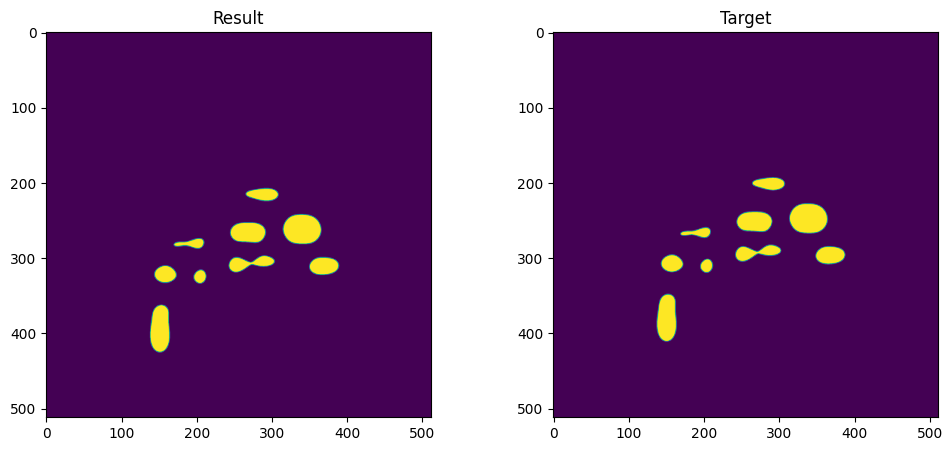

In [8]:
from matplotlib import pyplot as plt

train_loader, val_loader = make_dataloaders(DATASET, batch_size=1, num_zernike=6)
a = next(iter(train_loader))
i = 0

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,2,1)
plt.imshow(a[0][i][0])
ax.set_title("Result")
ax = plt.subplot(1,2,2)
plt.imshow(a[0][i][1])
ax.set_title("Target")
print(f"Aberrations: Z={a[1][i].numpy()}")
plt.show()

In [ ]:
# -------- 4. Training --------
train_loader, val_loader = make_dataloaders(DATASET, batch_size=48, num_zernike=6)
model = LithoZernikeRegressor(num_zernike=6)
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    save_top_k=1,
    mode='min',
    filename='best-model'
)
trainer = Trainer(max_epochs=15, accelerator="auto", callbacks=[checkpoint_callback],
                  accumulate_grad_batches = 4, gradient_clip_val=1., precision="16-mixed")
trainer.fit(model, train_loader, val_loader)

/root/anaconda3/envs/SK/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/anaconda3/envs/SK/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:02<00:00, 9.99MB/s]
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/root/anaconda3/envs/SK/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more detail

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Получить финальный val_loss
final_val_loss = trainer.callback_metrics['val_loss'].item()
print('Final validation loss:', final_val_loss)

# Где лежит best checkpoint
print('Best model saved at:', checkpoint_callback.best_model_path)

# Сохранить вручную
torch.save(model.state_dict(), 'final_model.pt')